© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/phd_students/seleznova/index.html) 2022

https://github.com/mselezniova/MSML22

Distributed under the [Creative Commons Attribution License](https://creativecommons.org/licenses/by/4.0/)

In [10]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

import matplotlib
import matplotlib.pyplot as plt

import os

import numpy as np
import pandas as pd


import sys
sys.path.append('../../')

from models import LinearMulticlassClassification, MulticlassLogisticRegression, SoftmaxRegression
from utils import train_test_split, normalize

# Model comparison

We first implement **one-vs-rest** multiclass linear SVM model based on our ```LinearMulticlassClassification``` class. The output of the model is given by:

$$h(x) = \underset{k\in\{1,\dots,K\}}{\operatorname{argmax}} \langle w_k, x \rangle + b_k,$$

where $K\in\mathbb{N}$ is the number of classes, $d\in\mathbb{N}$ is the input dimension, $W=[w_1,\dots,w_K]\in\mathbb{R}^{d\times K}$ is the matrix of weights and $B = [b_1,\dots,b_2]\in\mathbb{R}^K$ is the vector of biases. The risk function is the sum of all the risks corresponding to binary models:


$$\min_{W,B}{\|W\|^2_2} + C \sum_{i=1}^N\sum_{k=1}^K \max\bigl(0,1-y_i[k](\langle w_k,x_i \rangle + b_k)\bigr) = $$

$$= \min_{W,B}{\|W\|^2_2} + C \|\max\bigl(0,1-Y\odot(XW+B)\bigr)\|_1$$

In [2]:
class MulticlassSVM(LinearMulticlassClassification):
    
    def __init__(self, w, b, C=1.):
        
        super().__init__(w,b)
        self.C = C
        
        
    def _loss(self, X, Y):
        pred = X@self._params
        slack = (1 - Y * pred)
        
        return np.linalg.norm(self._w) + self.C*np.sum(slack[slack > 0])
    
    def _loss_grad(self, X,Y):
        
        pred = X@self._params
        slack = (1. - Y * pred)

        dw_slack = -np.where(slack > 0, Y, 0)[:,np.newaxis,:] * X[:,:,np.newaxis]
        dw_hinge = np.sum(dw_slack, axis=0)
        
        return 2*self._w + self.C*dw_hinge[:-1,:], self.C*dw_hinge[-1,:]

Load the letter recognition dataset:

In [3]:
file_name = 'letter-recognition.data'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data'
column_names = ['letter','x-box','y-box','width','high','onpix','x-bar','y-bar','x2bar','y2bar','xybar',
               'x2ybr','xy2br','x-ege','xegvy','y-ege','yegvx']
    
if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name, index_col=0)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url, names=column_names)
    df.to_csv(file_name)
    print('Done.')

Loading data from local file `letter-recognition.data`...


Train-test split:

In [6]:
df, train_df, test_df =  train_test_split(df, training_data_fraction=0.8)

X = df.iloc[:,1:].to_numpy()
Y = df['letter'].to_numpy()

train_X = train_df.iloc[:,1:].to_numpy()
train_Y = train_df['letter'].to_numpy()

test_X = test_df.iloc[:,1:].to_numpy()
test_Y = test_df['letter'].to_numpy()

Now we will train our **linear SVM** model on the dataset and compare it to other multiclass classification models implemented earlier in the class: **one-vs-rest linear (least squares) classification, one-vs-rest logistic regression, softmax regression**.

### Linear SVM 

In [33]:
K = np.unique(Y).size
w = np.zeros((X.shape[1],K))
b = [0]*np.unique(Y).size

model = MulticlassSVM(w,b, C=100.)
model.train(train_X, train_Y, lr = 2e-9, num_iter = 10000, verbose=True)

Epoch 0/10000. Loss value: 4502000.804497877, accuracy: 0.19456249999999997
Epoch 100/10000. Loss value: 3366344.524880598, accuracy: 0.5143125
Epoch 200/10000. Loss value: 3290837.755488149, accuracy: 0.5643750000000001
Epoch 300/10000. Loss value: 3244743.5642851647, accuracy: 0.5871875
Epoch 400/10000. Loss value: 3208869.1305453335, accuracy: 0.5970625
Epoch 500/10000. Loss value: 3178298.6434060824, accuracy: 0.602
Epoch 600/10000. Loss value: 3151673.8489292385, accuracy: 0.6040625
Epoch 700/10000. Loss value: 3128779.1148297386, accuracy: 0.6074999999999999
Epoch 800/10000. Loss value: 3107497.834644149, accuracy: 0.6094375000000001
Epoch 900/10000. Loss value: 3087126.378712958, accuracy: 0.611
Epoch 1000/10000. Loss value: 3067572.154512916, accuracy: 0.6119375
Epoch 1100/10000. Loss value: 3048719.7399535305, accuracy: 0.612625
Epoch 1200/10000. Loss value: 3030426.863084006, accuracy: 0.612375
Epoch 1300/10000. Loss value: 3012807.5006636605, accuracy: 0.612
Epoch 1400/10000

(array([[-2.37399757e-01,  1.22500273e-02,  3.69414336e-02,
         -2.95777382e-02,  3.57796856e-03, -4.73234621e-02,
          1.18083589e-02,  1.03860240e-02, -1.52834931e-01,
         -1.98786599e-02, -5.02905175e-04, -7.23497628e-02,
         -5.20746397e-02, -1.37680828e-02,  1.99654636e-02,
         -4.12753734e-02,  4.11014940e-02, -4.60740611e-02,
          6.10374465e-03,  1.13229869e-01,  1.26702645e-01,
         -1.32607851e-02,  7.26965640e-03, -3.03272618e-02,
          1.13746843e-01, -9.81581080e-02],
        [ 5.42013856e-02,  1.45010816e-04, -3.66239826e-04,
          1.48513500e-02,  1.81793839e-04, -1.87010042e-03,
          2.83046006e-03, -2.23028610e-03,  1.32405247e-01,
         -1.60293046e-01, -4.98118228e-03,  5.09006009e-02,
         -5.66732835e-02,  7.43176019e-03,  3.19376257e-04,
         -2.04671065e-02, -3.52499984e-02,  5.93033384e-03,
          1.53484420e-02,  2.37028333e-02,  3.86739046e-02,
          5.72660382e-02, -2.02571813e-02,  3.19293450e-

The final train accuracy: 64.5%
Test accuracy: 64.0%


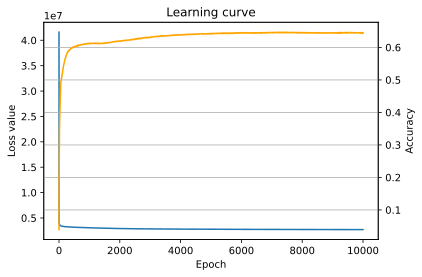

In [34]:
fig, ax = plt.subplots()

loss_history = [h['loss'] for h in model.history]
acc_history = [h['accuracy'] for h in model.history]

ax.plot(range(len(model.history)), loss_history)
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(model.history)), acc_history, color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {round(100*acc_history[-1],1)}%')
print(f'Test accuracy: {round(100*model.accuracy(test_X, test_Y),1)}%')

### Softmax regression

In [11]:
w = np.zeros((X.shape[1],np.unique(Y).size))
b = [0]*np.unique(Y).size

model = SoftmaxRegression(w,b)
model.train(train_X, train_Y, lr = 5e-2, num_iter = 10000, verbose=True)

Epoch 0/10000. Loss value: 0.12334991650992011, accuracy: 0.19456249999999997
Epoch 100/10000. Loss value: 0.06585403399438228, accuracy: 0.6303125
Epoch 200/10000. Loss value: 0.05506666866923763, accuracy: 0.67425
Epoch 300/10000. Loss value: 0.0500183638869488, accuracy: 0.6955625
Epoch 400/10000. Loss value: 0.04697427637724164, accuracy: 0.7109375
Epoch 500/10000. Loss value: 0.044901105250463355, accuracy: 0.720125
Epoch 600/10000. Loss value: 0.043383537900688385, accuracy: 0.726125
Epoch 700/10000. Loss value: 0.042217884219859156, accuracy: 0.73125
Epoch 800/10000. Loss value: 0.04129100570749222, accuracy: 0.7361875
Epoch 900/10000. Loss value: 0.040534459851588225, accuracy: 0.73875
Epoch 1000/10000. Loss value: 0.039904167544679015, accuracy: 0.74175
Epoch 1100/10000. Loss value: 0.039370337864302274, accuracy: 0.7441875
Epoch 1200/10000. Loss value: 0.03891204685811983, accuracy: 0.746375
Epoch 1300/10000. Loss value: 0.038514128159717415, accuracy: 0.7466875
Epoch 1400/10

(array([[-7.56135028e-01, -7.76113746e-02,  5.74927597e-01,
         -2.64581717e-01, -2.52721270e-01, -4.00861034e-01,
          1.63851349e-01, -1.88798246e-01, -1.80656318e-02,
         -1.12871847e-01, -1.52969293e-01, -3.23204332e-01,
          2.57386067e-01, -3.11195742e-01,  1.55335536e-01,
          6.53378558e-02,  7.20214064e-01, -3.17336145e-01,
         -3.26152240e-01,  5.42546141e-01,  4.69086225e-01,
          3.18117940e-01,  3.98416018e-01, -4.05870538e-01,
          4.41441832e-01, -1.98286187e-01],
        [ 1.69835961e-01,  6.66581575e-02,  1.30284676e-01,
          2.32575904e-01,  9.81681187e-02, -4.10590532e-03,
          1.05436891e-01, -1.22375676e-01,  1.90056334e-01,
         -2.99509573e-01, -7.61970882e-03,  3.30785405e-01,
         -2.62172804e-02,  2.60195115e-03,  1.70674852e-02,
         -2.84597683e-01, -3.40413643e-01,  1.08254209e-01,
          4.53856272e-02,  2.41528648e-01,  1.27544069e-01,
          1.04196663e-01, -2.40011885e-01,  3.08730701e-

The final train accuracy: 76.8%
Test accuracy: 76.2%


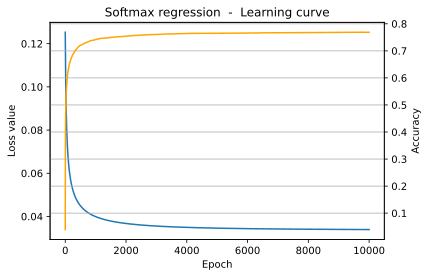

In [12]:
fig, ax = plt.subplots()

loss_history = [h['loss'] for h in model.history]
acc_history = [h['accuracy'] for h in model.history]

ax.plot(range(len(model.history)), loss_history)
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(model.history)), acc_history, color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Softmax regression  -  Learning curve')
plt.grid()

print(f'The final train accuracy: {round(100*acc_history[-1],1)}%')
print(f'Test accuracy: {round(100*model.accuracy(test_X, test_Y),1)}%')

### OvR Logistic regression

In [13]:
w = np.zeros((X.shape[1],np.unique(Y).size))
b = [0]*np.unique(Y).size

model = MulticlassLogisticRegression(w,b)
model.train(train_X, train_Y, lr = 5e-2, num_iter = 10000, verbose=True)

Epoch 0/10000. Loss value: 0.5416246591645989, accuracy: 0.19456249999999997
Epoch 100/10000. Loss value: 0.10692781630978004, accuracy: 0.6223125
Epoch 200/10000. Loss value: 0.09773396267675352, accuracy: 0.652
Epoch 300/10000. Loss value: 0.09361606292300617, accuracy: 0.6681250000000001
Epoch 400/10000. Loss value: 0.09121319441728698, accuracy: 0.67675
Epoch 500/10000. Loss value: 0.0896240418453685, accuracy: 0.6833125
Epoch 600/10000. Loss value: 0.08849193388977974, accuracy: 0.6875625000000001
Epoch 700/10000. Loss value: 0.0876439244338102, accuracy: 0.6918124999999999
Epoch 800/10000. Loss value: 0.0869851057584474, accuracy: 0.69425
Epoch 900/10000. Loss value: 0.08645883102094348, accuracy: 0.6965
Epoch 1000/10000. Loss value: 0.08602912055740528, accuracy: 0.6983125
Epoch 1100/10000. Loss value: 0.08567198548812463, accuracy: 0.6989375
Epoch 1200/10000. Loss value: 0.08537079481646372, accuracy: 0.70075
Epoch 1300/10000. Loss value: 0.08511364268038063, accuracy: 0.701937

(array([[-0.8143148 ,  0.1048147 ,  0.42166726, -0.09173621, -0.06747921,
         -0.51604899,  0.12790292, -0.06898654,  0.08909555,  0.03466106,
         -0.13743004, -0.18718984, -0.10509632, -0.50857672,  0.30023972,
          0.01896865,  0.57199106, -0.16953731, -0.05609286,  0.48287916,
          0.55907126,  0.15283328, -0.01361422, -0.49553026,  0.30920582,
         -0.10662198],
        [ 0.19508375,  0.05025399,  0.08451968,  0.22710653,  0.10160743,
          0.04560397,  0.08833357, -0.01864022,  0.30448322, -0.42482172,
         -0.03986639,  0.35101375, -0.0050838 ,  0.13506997,  0.06636774,
         -0.15226276, -0.31723241,  0.12440698,  0.18120696,  0.2039267 ,
          0.19533982,  0.30518638, -0.03667608,  0.07351427, -0.31072698,
         -0.39598145],
        [ 1.03678765, -0.63853514, -0.39950395, -0.79021409, -0.58018865,
         -0.13116149,  0.09560774,  0.52801346, -1.67818635, -0.52306532,
          0.57197882, -0.24777268,  0.45399186,  0.55198775, -0.35

The final train accuracy: 71.0%
Test accuracy: 70.7%


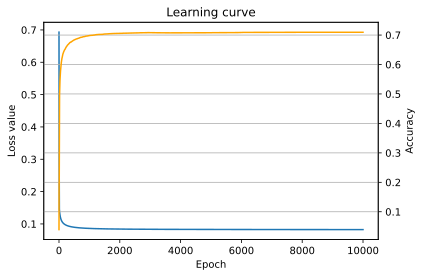

In [14]:
fig, ax = plt.subplots()

loss_history = [h['loss'] for h in model.history]
acc_history = [h['accuracy'] for h in model.history]

ax.plot(range(len(model.history)), loss_history)
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(model.history)), acc_history, color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {round(100*acc_history[-1],1)}%')
print(f'Test accuracy: {round(100*model.accuracy(test_X, test_Y),1)}%')

### OvR Linear (least squares) classification

In [15]:
w = np.zeros((X.shape[1],np.unique(Y).size))
b = [0]*np.unique(Y).size

model = LinearMulticlassClassification(w,b)
model.train(train_X, train_Y, lr = 1e-4, num_iter = 20000, verbose=True)

Epoch 0/20000. Loss value: 0.01910881552684018, accuracy: 0.19456249999999997
Epoch 100/20000. Loss value: 0.00798425255289949, accuracy: 0.371625
Epoch 200/20000. Loss value: 0.00789012987917275, accuracy: 0.4245
Epoch 300/20000. Loss value: 0.007814189512637248, accuracy: 0.44099999999999995
Epoch 400/20000. Loss value: 0.007752099163290758, accuracy: 0.4526875
Epoch 500/20000. Loss value: 0.007700684717543259, accuracy: 0.46081249999999996
Epoch 600/20000. Loss value: 0.007657583358698166, accuracy: 0.46806250000000005
Epoch 700/20000. Loss value: 0.007621025251569566, accuracy: 0.4745625
Epoch 800/20000. Loss value: 0.007589674696082371, accuracy: 0.4791875
Epoch 900/20000. Loss value: 0.007562514992023722, accuracy: 0.48275
Epoch 1000/20000. Loss value: 0.007538765069117846, accuracy: 0.4845625
Epoch 1100/20000. Loss value: 0.007517819041698176, accuracy: 0.488625
Epoch 1200/20000. Loss value: 0.007499202248368175, accuracy: 0.4919375
Epoch 1300/20000. Loss value: 0.00748253913397

Epoch 11200/20000. Loss value: 0.007225754477161839, accuracy: 0.5406875
Epoch 11300/20000. Loss value: 0.007225395829532084, accuracy: 0.5408124999999999
Epoch 11400/20000. Loss value: 0.0072250441525863315, accuracy: 0.5409999999999999
Epoch 11500/20000. Loss value: 0.007224699251695244, accuracy: 0.5413125
Epoch 11600/20000. Loss value: 0.007224360938797142, accuracy: 0.54125
Epoch 11700/20000. Loss value: 0.007224029032137473, accuracy: 0.54125
Epoch 11800/20000. Loss value: 0.007223703356020318, accuracy: 0.5416875
Epoch 11900/20000. Loss value: 0.007223383740571291, accuracy: 0.5416875
Epoch 12000/20000. Loss value: 0.0072230700215112, accuracy: 0.542125
Epoch 12100/20000. Loss value: 0.007222762039939965, accuracy: 0.5423125
Epoch 12200/20000. Loss value: 0.0072224596421301985, accuracy: 0.5424375
Epoch 12300/20000. Loss value: 0.007222162679329995, accuracy: 0.5426875
Epoch 12400/20000. Loss value: 0.007221871007574447, accuracy: 0.5426875
Epoch 12500/20000. Loss value: 0.00722

(array([[-1.42274233e-02,  4.50839229e-03,  1.83276982e-02,
         -5.57689924e-03, -2.77704789e-03, -1.41448696e-02,
          1.60511079e-02,  8.76965676e-03, -1.01634570e-02,
         -8.59546384e-04,  4.83426504e-03,  4.07159380e-03,
         -2.47595471e-03,  2.73155833e-03,  1.46021784e-02,
         -1.76964863e-03,  3.35345620e-02,  6.35369779e-03,
          9.48087841e-03,  2.65228319e-02,  2.79114130e-02,
          1.65849691e-02,  1.03549152e-02, -6.58625574e-03,
          2.63235627e-02,  3.25208142e-04],
        [ 2.13970567e-03,  5.25039274e-03,  1.60421137e-03,
          4.77173843e-03,  4.42968681e-03,  1.63504637e-04,
          4.22360835e-03, -5.44387976e-03,  1.71026182e-02,
         -1.66846718e-02, -3.60306612e-03,  6.95689882e-03,
         -1.01708993e-02,  4.91411186e-04,  5.22893808e-03,
         -4.86616805e-03, -3.34702901e-02,  4.00492146e-03,
          9.18579313e-03,  8.90179842e-03,  1.26042578e-03,
          1.20729595e-02, -5.68346118e-03,  8.23758688e-

The final train accuracy: 54.8%
Test accuracy: 53.9%


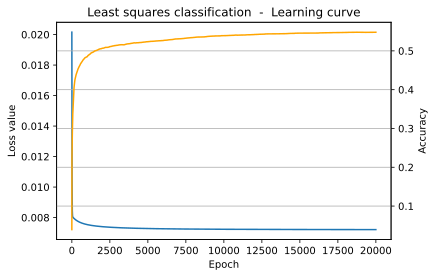

In [16]:
fig, ax = plt.subplots()

loss_history = [h['loss'] for h in model.history]
acc_history = [h['accuracy'] for h in model.history]

ax.plot(range(len(model.history)), loss_history)
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(model.history)), acc_history, color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Least squares classification  -  Learning curve')
plt.grid()

print(f'The final train accuracy: {round(100*acc_history[-1],1)}%')
print(f'Test accuracy: {round(100*model.accuracy(test_X, test_Y),1)}%')